In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from constants import CLASSES
from pathlib import Path
from utils import train_net

In [46]:
# for colab
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/deadskull7/fer2013/download" -O fer2013.zip
!python unpack_data.py

--2020-04-11 09:14:45--  https://www.kaggle.com/deadskull7/fer2013/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-data-sets/28577/36420/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586855685&Signature=MOWv3ng3O6JIMdRyAlBd6y0zpESiDf85XSyJFO37SIwt0Wt4cnTBkB8foJBHcvDPaIZ1CdZrghB%2BDMLgsV3hq%2BjI5%2FF%2BZJ1pAB4f16Go%2F%2FPqI5XwNKNHMuiLum2VWKEBYHFOfHUCYmRkymFygVfm4shq8PXIsuhBHXkHkqMz%2FUklaM5yQNDPWT%2Br8eLXVqG0IVgQ%2FcOLZaVg10TQqTYEqlw92XcDNmqXnLXnY2Rafh1zgl9BZkVDguYKw1Yly4mdP1pTb2iuGFhtla39q12gCts1YPp%2Fn3m%2FZkUYZ9TSO7xk1kAvYxDSaW1svTCSiUBE8%2BpNqJ2V0DYMLXSDSNwo%2Fg%3D%3D&response-content-disposition=attachment%3B+filename%3Dfer2013.zip [following]
--2020-04-11 09:14:45--  https://storage.googleapis.com/kaggle-data-sets/28577/36420/bundle/archive.zip

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

transform_augment = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.Grayscale(),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.2),
     transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [0]:
trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform_augment)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

In [0]:
valset = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [0]:
net = torchvision.models.vgg16()
net.features[0] = nn.Conv2d(1, 64, 3, 1, padding=1, padding_mode='zeros')
net.classifier[6] = nn.Linear(in_features=4096, out_features=len(CLASSES), bias=True)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=0.001)

[1,   449] train_loss: 1.813, val_loss: 1.708, val_acc: 0.312
[2,   449] train_loss: 1.635, val_loss: 1.466, val_acc: 0.425
[3,   449] train_loss: 1.396, val_loss: 1.255, val_acc: 0.520
[4,   449] train_loss: 1.265, val_loss: 1.183, val_acc: 0.555
[5,   449] train_loss: 1.170, val_loss: 1.218, val_acc: 0.548
[6,   449] train_loss: 1.122, val_loss: 1.083, val_acc: 0.588
[7,   449] train_loss: 1.077, val_loss: 1.109, val_acc: 0.587
[8,   449] train_loss: 1.044, val_loss: 1.078, val_acc: 0.601
[9,   449] train_loss: 1.008, val_loss: 1.055, val_acc: 0.614
[10,   449] train_loss: 0.983, val_loss: 1.004, val_acc: 0.629
[11,   449] train_loss: 0.956, val_loss: 1.016, val_acc: 0.618
[12,   449] train_loss: 0.930, val_loss: 0.999, val_acc: 0.636
[13,   449] train_loss: 0.908, val_loss: 0.994, val_acc: 0.640
[14,   449] train_loss: 0.887, val_loss: 0.993, val_acc: 0.649
[15,   449] train_loss: 0.859, val_loss: 0.985, val_acc: 0.643
[16,   449] train_loss: 0.841, val_loss: 0.968, val_acc: 0.653
[

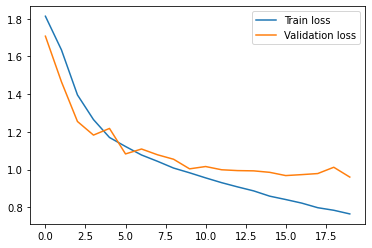

In [9]:
train_net(net, trainloader, valloader, criterion, optimizer, device, 
          num_epochs=20, lr_scheduler=scheduler, eval_period=len(trainloader))

In [0]:
Path('weights').mkdir(exist_ok=True)
PATH = 'weights/vgg16.pth'
torch.save(net.state_dict(), PATH)

### Evaluating

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
net = torchvision.models.vgg16()
net.features[0] = nn.Conv2d(1, 64, 3, 1, padding=1, padding_mode='zeros')
net.classifier[6] = nn.Linear(in_features=4096, out_features=len(CLASSES), bias=True)

In [13]:
net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
testset = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
testloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 66 %


In [16]:
class_correct = [0. for i in range(len(CLASSES))]
class_total = [0. for i in range(len(CLASSES))]
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).reshape(1, -1)
        for i in range(c.size()[1]):
            label = labels[i].item()
            class_correct[label] += c[0, i].item()
            class_total[label] += 1


for i in range(len(CLASSES)):
    print('Accuracy of %5s : %2d %%' % (
        CLASSES[i], 100 * class_correct[i] / class_total[i]))

Accuracy of angry : 60 %
Accuracy of disgust : 48 %
Accuracy of  fear : 36 %
Accuracy of happy : 87 %
Accuracy of   sad : 58 %
Accuracy of surprise : 81 %
Accuracy of neutral : 66 %
